In [4]:
"""
BERT-based Phishing Email Detection with Cross-Dataset Evaluation
For use in Google Colab
"""

# ============================================================================
# SECTION 1: SETUP AND INSTALLATION
# ============================================================================

# Install required packages (suppress output)
import sys
import subprocess

print("Installing packages... (this may take a minute)")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                      "transformers", "datasets", "scikit-learn",
                      "pandas", "matplotlib", "seaborn", "torch"])
print("✓ Installation complete!")

# Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW  # ← FIXED: Import from torch.optim instead
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

# ============================================================================
# SECTION 2: MOUNT GOOGLE DRIVE AND LOAD DATA
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

# File paths - ADJUST THESE TO YOUR GOOGLE DRIVE PATHS
DATASET1_PATH = "/content/drive/MyDrive/CleanedProjectDatasets/Dataset1.csv"
DATASET2_PATH = "/content/drive/MyDrive/CleanedProjectDatasets/Dataset2.csv"
DATASET3_PATH = "/content/drive/MyDrive/CleanedProjectDatasets/Dataset3.csv"

# Load datasets
print("\nLoading datasets...")
df1 = pd.read_csv(DATASET1_PATH)
df2 = pd.read_csv(DATASET2_PATH)
df3 = pd.read_csv(DATASET3_PATH)

# Display basic information
print("\n=== Dataset Information ===")
print(f"Dataset 1: {len(df1)} samples")
print(f"  - Phishing: {sum(df1['label'] == 1)}")
print(f"  - Legitimate: {sum(df1['label'] == 0)}")

print(f"\nDataset 2: {len(df2)} samples")
print(f"  - Phishing: {sum(df2['label'] == 1)}")
print(f"  - Legitimate: {sum(df2['label'] == 0)}")

print(f"\nDataset 3: {len(df3)} samples")
print(f"  - Phishing: {sum(df3['label'] == 1)}")
print(f"  - Legitimate: {sum(df3['label'] == 0)}")

# ============================================================================
# SECTION 3: DATA PREPROCESSING
# ============================================================================

def clean_text(text):
    """Basic text cleaning"""
    if pd.isna(text):
        return ""
    text = str(text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Clean email text in all datasets
print("\nCleaning text...")
df1['email_text'] = df1['email_text'].apply(clean_text)
df2['email_text'] = df2['email_text'].apply(clean_text)
df3['email_text'] = df3['email_text'].apply(clean_text)

# Remove any rows with empty text
df1 = df1[df1['email_text'].str.len() > 0].reset_index(drop=True)
df2 = df2[df2['email_text'].str.len() > 0].reset_index(drop=True)
df3 = df3[df3['email_text'].str.len() > 0].reset_index(drop=True)

print("✓ Text cleaning complete.")

Installing packages... (this may take a minute)
✓ Installation complete!

✓ Using device: cpu
Mounted at /content/drive

Loading datasets...

=== Dataset Information ===
Dataset 1: 4000 samples
  - Phishing: 2000
  - Legitimate: 2000

Dataset 2: 10000 samples
  - Phishing: 6000
  - Legitimate: 4000

Dataset 3: 38164 samples
  - Phishing: 20856
  - Legitimate: 17308

Cleaning text...
✓ Text cleaning complete.


In [5]:
# ============================================================================
# SECTION 4: CUSTOM DATASET CLASS FOR BERT
# ============================================================================

class PhishingEmailDataset(Dataset):
    """Custom Dataset for BERT tokenization"""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# ============================================================================
# SECTION 5: MODEL TRAINING FUNCTION
# ============================================================================

def train_bert_model(train_df, val_df, model_name='bert-base-uncased',
                     epochs=3, batch_size=16, learning_rate=2e-5,
                     max_length=512):
    """
    Train BERT model on phishing email dataset

    Args:
        train_df: Training dataframe with 'email_text' and 'label'
        val_df: Validation dataframe
        model_name: Pre-trained BERT model name
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate
        max_length: Maximum sequence length

    Returns:
        Trained model, tokenizer
    """

    print(f"\n{'='*60}")
    print(f"Training BERT Model")
    print(f"{'='*60}")
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")

    # Initialize tokenizer and model
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    model.to(device)

    # Create datasets
    train_dataset = PhishingEmailDataset(
        train_df['email_text'].values,
        train_df['label'].values,
        tokenizer,
        max_length
    )

    val_dataset = PhishingEmailDataset(
        val_df['email_text'].values,
        val_df['label'].values,
        tokenizer,
        max_length
    )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        total_train_loss = 0

        progress_bar = tqdm(train_loader, desc='Training')
        for batch in progress_bar:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_val_loss += outputs.loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print("  → Best model so far!")

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, tokenizer

# ============================================================================
# SECTION 6: EVALUATION FUNCTION
# ============================================================================

def evaluate_model(model, tokenizer, test_df, batch_size=16, max_length=512):
    """
    Evaluate BERT model on test dataset

    Args:
        model: Trained BERT model
        tokenizer: BERT tokenizer
        test_df: Test dataframe with 'email_text' and 'label'
        batch_size: Batch size for evaluation
        max_length: Maximum sequence length

    Returns:
        Dictionary with performance metrics
    """

    model.eval()

    # Create dataset and dataloader
    test_dataset = PhishingEmailDataset(
        test_df['email_text'].values,
        test_df['label'].values,
        tokenizer,
        max_length
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Collect predictions
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds,
                                target_names=['Legitimate', 'Phishing']))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legitimate', 'Phishing'],
                yticklabels=['Legitimate', 'Phishing'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'true_labels': all_labels
    }

# ============================================================================
# SECTION 7: CROSS-DATASET EXPERIMENT FUNCTION
# ============================================================================

def run_cross_dataset_experiment(datasets_dict, epochs=3, batch_size=16):
    """
    Run complete cross-dataset experiment

    Args:
        datasets_dict: Dictionary with dataset names as keys and dataframes as values
        epochs: Number of training epochs
        batch_size: Batch size

    Returns:
        Results dictionary with all metrics
    """

    results = {}
    dataset_names = list(datasets_dict.keys())

    for train_name in dataset_names:
        print(f"\n{'='*70}")
        print(f"TRAINING ON: {train_name}")
        print(f"{'='*70}")

        # Get training dataset
        train_full = datasets_dict[train_name]

        # Split into train/val (80/20)
        train_df, val_df = train_test_split(
            train_full,
            test_size=0.2,
            random_state=42,
            stratify=train_full['label']
        )

        # Train model
        model, tokenizer = train_bert_model(
            train_df,
            val_df,
            epochs=epochs,
            batch_size=batch_size
        )

        # Test on all datasets
        for test_name in dataset_names:
            print(f"\n--- Testing on: {test_name} ---")

            test_df = datasets_dict[test_name]

            # If testing on same dataset, use only the test split
            if test_name == train_name:
                _, test_df = train_test_split(
                    test_df,
                    test_size=0.2,
                    random_state=42,
                    stratify=test_df['label']
                )

            metrics = evaluate_model(model, tokenizer, test_df, batch_size=batch_size)

            # Store results
            key = f"{train_name} → {test_name}"
            results[key] = metrics

            print(f"\nResults for {key}:")
            print(f"  Accuracy:  {metrics['accuracy']:.4f}")
            print(f"  Precision: {metrics['precision']:.4f}")
            print(f"  Recall:    {metrics['recall']:.4f}")
            print(f"  F1 Score:  {metrics['f1']:.4f}")

    return results

# ============================================================================
# SECTION 8: VISUALIZATION FUNCTIONS
# ============================================================================

def plot_cross_dataset_results(results):
    """Create heatmap of cross-dataset performance"""

    # Extract dataset names
    dataset_names = sorted(list(set([k.split(' → ')[0] for k in results.keys()])))

    # Create matrices for each metric
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        matrix = np.zeros((len(dataset_names), len(dataset_names)))

        for i, train_ds in enumerate(dataset_names):
            for j, test_ds in enumerate(dataset_names):
                key = f"{train_ds} → {test_ds}"
                if key in results:
                    matrix[i, j] = results[key][metric]

        sns.heatmap(matrix, annot=True, fmt='.3f', cmap='RdYlGn',
                   xticklabels=dataset_names, yticklabels=dataset_names,
                   vmin=0, vmax=1, ax=axes[idx], cbar_kws={'label': metric.capitalize()})
        axes[idx].set_title(f'{metric.capitalize()} - Cross-Dataset Performance')
        axes[idx].set_xlabel('Test Dataset')
        axes[idx].set_ylabel('Train Dataset')

    plt.tight_layout()
    plt.savefig('cross_dataset_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_results_table(results):
    """Create a pandas DataFrame with all results"""

    rows = []
    for key, metrics in results.items():
        train_ds, test_ds = key.split(' → ')
        rows.append({
            'Train Dataset': train_ds,
            'Test Dataset': test_ds,
            'Accuracy': f"{metrics['accuracy']:.4f}",
            'Precision': f"{metrics['precision']:.4f}",
            'Recall': f"{metrics['recall']:.4f}",
            'F1 Score': f"{metrics['f1']:.4f}"
        })

    df_results = pd.DataFrame(rows)
    return df_results

# ============================================================================
# SECTION 9: SAVE/LOAD FUNCTIONS
# ============================================================================

import pickle
import os
from datetime import datetime

# Create directories for saving
MODEL_DIR = '/content/drive/MyDrive/CleanedProjectDatasets/phishing_models'
RESULTS_DIR = '/content/drive/MyDrive/CleanedProjectDatasets/phishing_results'

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

def save_model(model, tokenizer, dataset_name):
    """Save trained model and tokenizer to Google Drive"""
    save_path = f"{MODEL_DIR}/{dataset_name}_bert"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"✓ Model saved to: {save_path}")

def load_model(dataset_name):
    """Load trained model and tokenizer from Google Drive"""
    load_path = f"{MODEL_DIR}/{dataset_name}_bert"
    if os.path.exists(load_path):
        model = BertForSequenceClassification.from_pretrained(load_path)
        tokenizer = BertTokenizer.from_pretrained(load_path)
        model.to(device)
        print(f"✓ Model loaded from: {load_path}")
        return model, tokenizer
    else:
        print(f"✗ Model not found at: {load_path}")
        return None, None

def save_results(results, filename='results.pkl'):
    """Save results dictionary to Google Drive"""
    save_path = f"{RESULTS_DIR}/{filename}"
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)
    print(f"✓ Results saved to: {save_path}")

def load_results(filename='results.pkl'):
    """Load results dictionary from Google Drive"""
    load_path = f"{RESULTS_DIR}/{filename}"
    if os.path.exists(load_path):
        with open(load_path, 'rb') as f:
            results = pickle.load(f)
        print(f"✓ Results loaded from: {load_path}")
        return results
    else:
        print(f"✗ Results not found at: {load_path}")
        return {}

def save_experiment_state(train_name, completed_tests, results):
    """Save experiment state for resuming"""
    state = {
        'train_name': train_name,
        'completed_tests': completed_tests,
        'results': results,
        'timestamp': datetime.now().isoformat()
    }
    save_path = f"{RESULTS_DIR}/experiment_state_{train_name}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump(state, f)
    print(f"✓ State saved: {train_name}")

def load_experiment_state(train_name):
    """Load experiment state for resuming"""
    load_path = f"{RESULTS_DIR}/experiment_state_{train_name}.pkl"
    if os.path.exists(load_path):
        with open(load_path, 'rb') as f:
            state = pickle.load(f)
        print(f"✓ State loaded for: {train_name}")
        return state
    return None

# ============================================================================
# SECTION 10: INDIVIDUAL EXPERIMENT RUNNER (RESUMABLE)
# ============================================================================

def run_single_training(train_name, train_df, val_df, epochs=3, batch_size=16, force_retrain=False):
    """
    Train model for a single dataset (with option to skip if already trained)

    Args:
        train_name: Name of training dataset
        train_df: Training dataframe
        val_df: Validation dataframe
        epochs: Number of epochs
        batch_size: Batch size
        force_retrain: If True, retrain even if model exists

    Returns:
        model, tokenizer
    """

    # Check if model already exists
    if not force_retrain:
        model, tokenizer = load_model(train_name)
        if model is not None:
            print(f"✓ Using existing model for {train_name}")
            return model, tokenizer

    # Train new model
    print(f"\n{'='*70}")
    print(f"TRAINING NEW MODEL: {train_name}")
    print(f"{'='*70}")

    model, tokenizer = train_bert_model(
        train_df,
        val_df,
        epochs=epochs,
        batch_size=batch_size
    )

    # Save the model
    save_model(model, tokenizer, train_name)

    return model, tokenizer

def run_single_experiment(train_name, test_name, datasets_dict,
                         epochs=3, batch_size=16, force_retrain=False):
    """
    Run a single train→test experiment

    Args:
        train_name: Dataset to train on
        test_name: Dataset to test on
        datasets_dict: Dictionary of all datasets
        epochs: Training epochs
        batch_size: Batch size
        force_retrain: Force retraining even if model exists

    Returns:
        metrics dictionary
    """

    experiment_key = f"{train_name} → {test_name}"
    print(f"\n{'='*70}")
    print(f"EXPERIMENT: {experiment_key}")
    print(f"{'='*70}")

    # Get training dataset and split
    train_full = datasets_dict[train_name]
    train_df, val_df = train_test_split(
        train_full,
        test_size=0.2,
        random_state=42,
        stratify=train_full['label']
    )

    # Train or load model
    model, tokenizer = run_single_training(
        train_name,
        train_df,
        val_df,
        epochs,
        batch_size,
        force_retrain
    )

    # Prepare test dataset
    test_df = datasets_dict[test_name]
    if test_name == train_name:
        # Use held-out test set
        _, test_df = train_test_split(
            test_df,
            test_size=0.2,
            random_state=42,
            stratify=test_df['label']
        )

    # Evaluate
    print(f"\n--- Testing on: {test_name} ---")
    metrics = evaluate_model(model, tokenizer, test_df, batch_size=batch_size)

    print(f"\nResults for {experiment_key}:")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")

    return metrics

# ============================================================================
# SECTION 11: MAIN EXECUTION (MODULAR & RESUMABLE)
# ============================================================================

# Prepare datasets dictionary
datasets = {
    'Dataset1': df1,
    'Dataset2': df2,
    'Dataset3': df3
}

# PARAMETERS
EPOCHS = 3
BATCH_SIZE = 16
FORCE_RETRAIN = False  # Set to True to retrain existing models

# Initialize or load existing results
results = load_results('bert_cross_dataset_results.pkl')

print("\n" + "="*70)
print("CROSS-DATASET BERT EXPERIMENT (MODULAR)")
print("="*70)
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Force Retrain: {FORCE_RETRAIN}")
print(f"Existing results: {len(results)} experiments")
print("="*70)



✓ Results loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

CROSS-DATASET BERT EXPERIMENT (MODULAR)
Epochs: 3
Batch Size: 16
Force Retrain: False
Existing results: 6 experiments



EXPERIMENT: Dataset1 → Dataset1
✗ Model not found at: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert

TRAINING NEW MODEL: Dataset1

Training BERT Model
Training samples: 3198
Validation samples: 800


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


  Train Loss: 0.1160
  Val Loss: 0.0244
  → Best model so far!

Epoch 2/3


Validation: 100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


  Train Loss: 0.0067
  Val Loss: 0.0101
  → Best model so far!

Epoch 3/3


Validation: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]

  Train Loss: 0.0005
  Val Loss: 0.0195


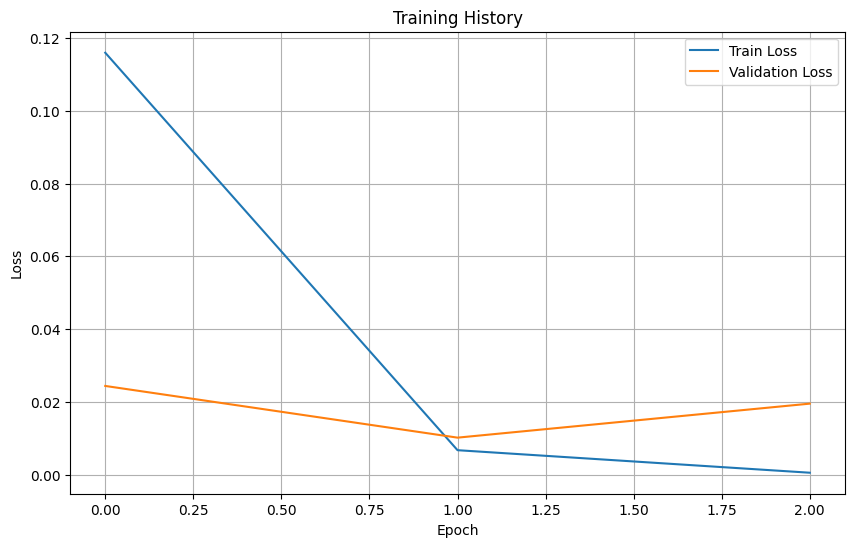

✓ Model saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert

--- Testing on: Dataset1 ---


Evaluating: 100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      1.00      1.00       400
    Phishing       1.00      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      0.99      0.99       800



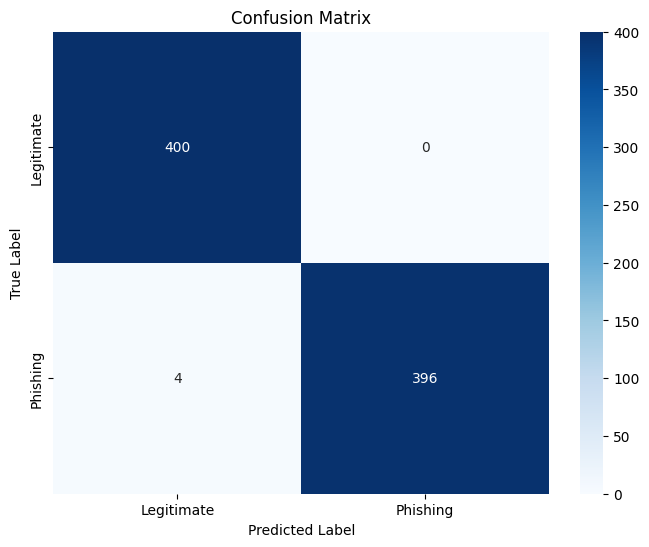


Results for Dataset1 → Dataset1:
  Accuracy:  0.9950
  Precision: 1.0000
  Recall:    0.9900
  F1 Score:  0.9950
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset1 → Dataset2
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert
✓ Using existing model for Dataset1

--- Testing on: Dataset2 ---


Evaluating: 100%|██████████| 625/625 [04:40<00:00,  2.23it/s]


Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.76      1.00      0.86      4000
    Phishing       1.00      0.79      0.88      6000

    accuracy                           0.88     10000
   macro avg       0.88      0.90      0.87     10000
weighted avg       0.90      0.88      0.88     10000



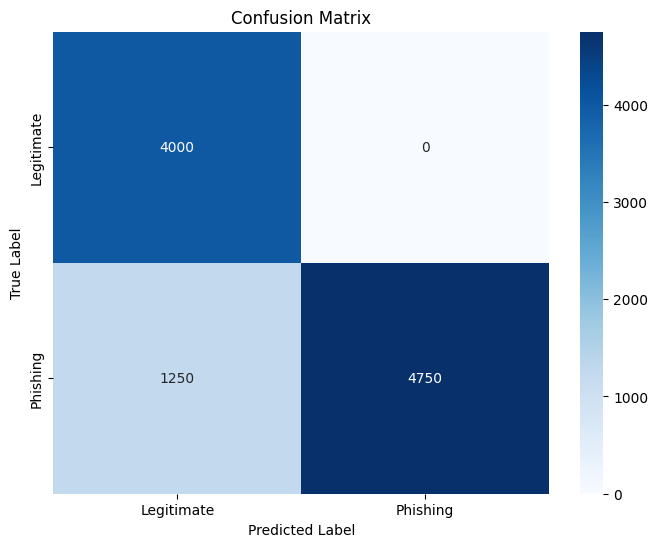


Results for Dataset1 → Dataset2:
  Accuracy:  0.8750
  Precision: 1.0000
  Recall:    0.7917
  F1 Score:  0.8837
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset1 → Dataset3
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset1_bert
✓ Using existing model for Dataset1

--- Testing on: Dataset3 ---


Evaluating: 100%|██████████| 2386/2386 [21:19<00:00,  1.86it/s]



Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.62      0.96      0.75     17308
    Phishing       0.93      0.51      0.66     20856

    accuracy                           0.71     38164
   macro avg       0.78      0.73      0.71     38164
weighted avg       0.79      0.71      0.70     38164



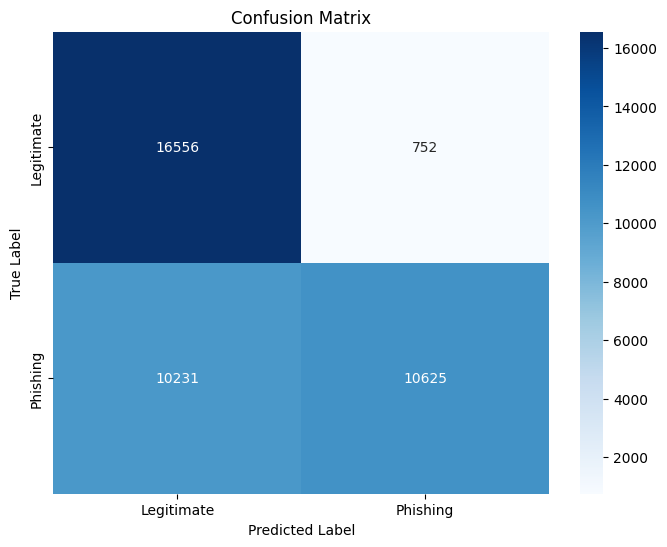


Results for Dataset1 → Dataset3:
  Accuracy:  0.7122
  Precision: 0.9339
  Recall:    0.5094
  F1 Score:  0.6593
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

✓ Dataset1 experiments complete!


In [ ]:

# --------------------------------------------------
# EXPERIMENT 1: Train on Dataset1
# --------------------------------------------------
train_name = 'Dataset1'
test_names = ['Dataset1', 'Dataset2', 'Dataset3']

for test_name in test_names:
    experiment_key = f"{train_name} → {test_name}"

    # Skip if already done
    if experiment_key in results:
        print(f"✓ Skipping {experiment_key} (already completed)")
        continue

    # Run experiment
    metrics = run_single_experiment(
        train_name,
        test_name,
        datasets,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        force_retrain=FORCE_RETRAIN
    )

    # Save results immediately
    results[experiment_key] = metrics
    save_results(results, 'bert_cross_dataset_results.pkl')

    # Also save as CSV incrementally
    results_df = create_results_table(results)
    results_df.to_csv(f'{RESULTS_DIR}/bert_results_progress.csv', index=False)

print("\n✓ Dataset1 experiments complete!")


EXPERIMENT: Dataset2 → Dataset1
✗ Model not found at: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert

TRAINING NEW MODEL: Dataset2

Training BERT Model
Training samples: 8000
Validation samples: 2000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


Validation: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]


  Train Loss: 0.0192
  Val Loss: 0.0001
  → Best model so far!

Epoch 2/3


Validation: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]


  Train Loss: 0.0001
  Val Loss: 0.0000
  → Best model so far!

Epoch 3/3


Validation: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]

  Train Loss: 0.0000
  Val Loss: 0.0000
  → Best model so far!


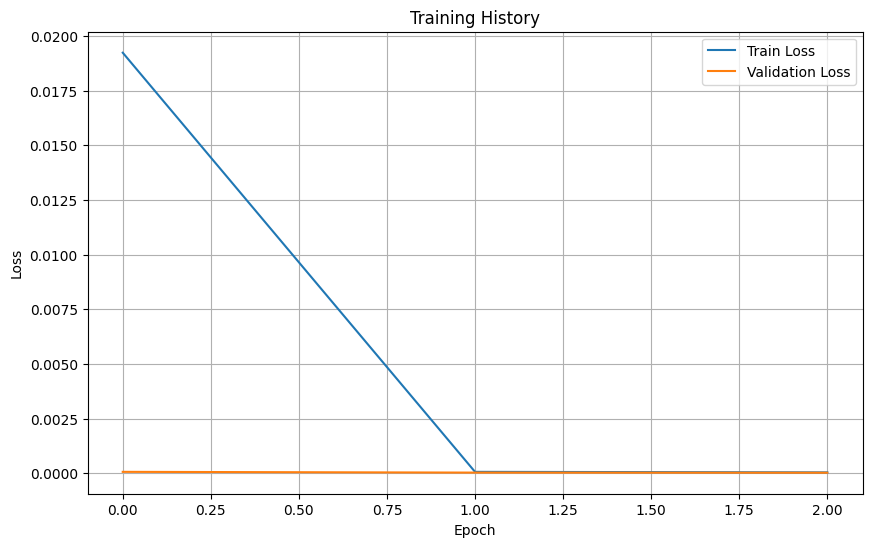

✓ Model saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert

--- Testing on: Dataset1 ---


Evaluating: 100%|██████████| 250/250 [02:06<00:00,  1.97it/s]


Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.00      0.00      0.00      2000
    Phishing       0.50      1.00      0.67      1998

    accuracy                           0.50      3998
   macro avg       0.25      0.50      0.33      3998
weighted avg       0.25      0.50      0.33      3998



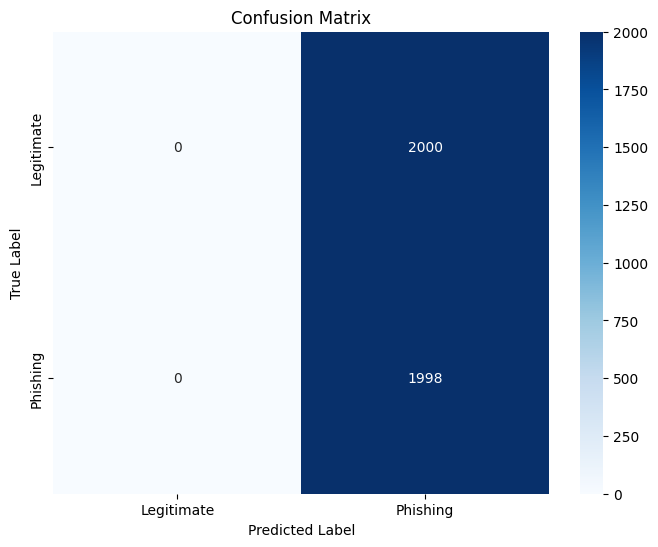


Results for Dataset2 → Dataset1:
  Accuracy:  0.4997
  Precision: 0.4997
  Recall:    1.0000
  F1 Score:  0.6664
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset2 → Dataset2
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert
✓ Using existing model for Dataset2

--- Testing on: Dataset2 ---


Evaluating: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]



Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00       800
    Phishing       1.00      1.00      1.00      1200

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



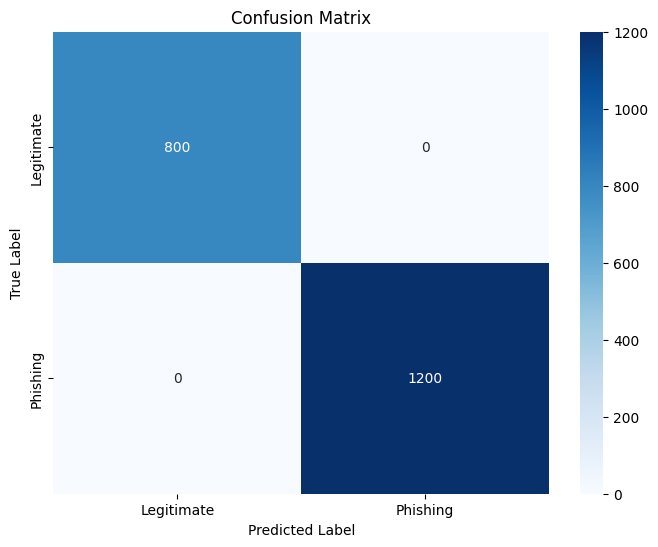


Results for Dataset2 → Dataset2:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

EXPERIMENT: Dataset2 → Dataset3
✓ Model loaded from: /content/drive/MyDrive/CleanedProjectDatasets/phishing_models/Dataset2_bert
✓ Using existing model for Dataset2

--- Testing on: Dataset3 ---


Evaluating: 100%|██████████| 2386/2386 [21:07<00:00,  1.88it/s]



Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.00      0.00      0.00     17308
    Phishing       0.55      1.00      0.71     20856

    accuracy                           0.55     38164
   macro avg       0.27      0.50      0.35     38164
weighted avg       0.30      0.55      0.39     38164



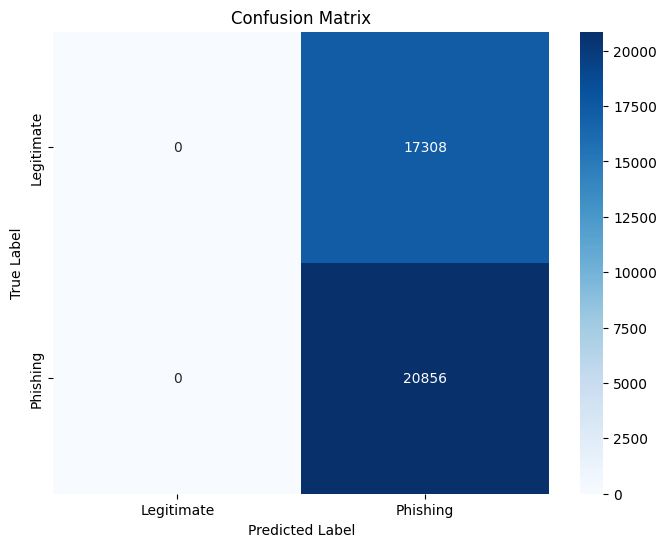


Results for Dataset2 → Dataset3:
  Accuracy:  0.5465
  Precision: 0.5465
  Recall:    1.0000
  F1 Score:  0.7067
✓ Results saved to: /content/drive/MyDrive/CleanedProjectDatasets/phishing_results/bert_cross_dataset_results.pkl

✓ Dataset2 experiments complete!


In [ ]:
# --------------------------------------------------
# EXPERIMENT 2: Train on Dataset2
# --------------------------------------------------
train_name = 'Dataset2'
test_names = ['Dataset1', 'Dataset2', 'Dataset3']

for test_name in test_names:
    experiment_key = f"{train_name} → {test_name}"

    if experiment_key in results:
        print(f"✓ Skipping {experiment_key} (already completed)")
        continue

    metrics = run_single_experiment(
        train_name,
        test_name,
        datasets,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        force_retrain=FORCE_RETRAIN
    )

    results[experiment_key] = metrics
    save_results(results, 'bert_cross_dataset_results.pkl')

    results_df = create_results_table(results)
    results_df.to_csv(f'{RESULTS_DIR}/bert_results_progress.csv', index=False)

print("\n✓ Dataset2 experiments complete!")

In [2]:
# --------------------------------------------------
# EXPERIMENT 3: Train on Dataset3
# --------------------------------------------------
train_name = 'Dataset3'
test_names = ['Dataset1', 'Dataset2', 'Dataset3']

for test_name in test_names:
    experiment_key = f"{train_name} → {test_name}"

    if experiment_key in results:
        print(f"✓ Skipping {experiment_key} (already completed)")
        continue

    metrics = run_single_experiment(
        train_name,
        test_name,
        datasets,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        force_retrain=FORCE_RETRAIN
    )

    results[experiment_key] = metrics
    save_results(results, 'bert_cross_dataset_results.pkl')

    results_df = create_results_table(results)
    results_df.to_csv(f'{RESULTS_DIR}/bert_results_progress.csv', index=False)

print("\n✓ Dataset3 experiments complete!")

NameError: name 'results' is not defined

In [ ]:
# --------------------------------------------------
# FINAL: Generate all visualizations
# --------------------------------------------------
print("\n" + "="*70)
print("GENERATING FINAL RESULTS")
print("="*70)

# Load all results
results = load_results('bert_cross_dataset_results.pkl')

# Create final results table
results_df = create_results_table(results)
print("\nFinal Results Table:")
print(results_df.to_string(index=False))

# Save final CSV
results_df.to_csv(f'{RESULTS_DIR}/bert_cross_dataset_results_FINAL.csv', index=False)

# Plot heatmaps
plot_cross_dataset_results(results)

# Performance drop analysis
print("\n=== Performance Drop Analysis ===")
for train_ds in ['Dataset1', 'Dataset2', 'Dataset3']:
    within_key = f"{train_ds} → {train_ds}"
    if within_key in results:
        within_f1 = results[within_key]['f1']

        print(f"\n{train_ds} (Within-dataset F1: {within_f1:.4f}):")

        for test_ds in ['Dataset1', 'Dataset2', 'Dataset3']:
            if test_ds != train_ds:
                cross_key = f"{train_ds} → {test_ds}"
                if cross_key in results:
                    cross_f1 = results[cross_key]['f1']
                    drop = within_f1 - cross_f1
                    drop_pct = (drop / within_f1) * 100

                    print(f"  → {test_ds}: F1 = {cross_f1:.4f} (drop: {drop:.4f}, {drop_pct:.1f}%)")

print("\n✓ ALL EXPERIMENTS COMPLETE!")
